# Model training and selection

In [16]:
import pickle
from tqdm.notebook import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

import torch
import torchvision.transforms as transforms
import torchvision.models
import torch.optim as optim
import torch.nn as nn

import time

In [17]:
name = "data_set_x10_5%"

with open(f"C:/Users/Alejandro/Desktop/heterogeneous-data/data/datasets/{name}.obj", 'rb') as f:
    data_set = pickle.load(f)


In [18]:
# Choosing device for tensor processing

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU :", device)
else:
    device = torch.device("cpu")
    print("Using CPU ")

Using GPU : cuda:0


In [19]:
patch_size = 300

SIZE_X = patch_size
SIZE_Y = patch_size

MODE = "a"
MODEL_NAME = "ejemplo"

In [20]:
def init_weights(m): # XAVIER initialization for final layer weight initialization
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def init():
  global net, loss_function, scheduler, optimizer, MODEL_NAME
  
  net = torchvision.models.resnet18(pretrained=True).to(device)
      
  for param in net.parameters():
      param.requires_grad = False # Freezing the convolutional layers
      
  net.fc = nn.Sequential(
                nn.Linear(512, 128), #512
                nn.ReLU(inplace=True),
                nn.Linear(128, 2),
                nn.Softmax(dim = -1)
                ).to(device)

  net.fc.apply(init_weights) # Xavier init

  print(f"loading {MODEL_NAME}")

  net.fc = torch.load(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth") # Model loading

  print("Number of free parameters: ", sum(p.numel() for p in net.parameters()))

  #Hyperparameters:
  learning_rate = 0.00001 # LR
  loss_function = nn.BCELoss()
  # Loss # [1,0] es positivo y [0,1] negativo # weight = torch.tensor([(495+201)/(2*495), (201+495)/(2*201)]).to(device)) # El negativo cuesta 2.5... mas
  optimizer = optim.Adam(net.parameters(), lr=learning_rate)# Optimizer
  lambda1 = lambda epoch: 0.8 ** epoch # Scheduler
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

init()

loading ejemplo


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\ejemplo.pth'

In [ ]:
def fwd_pass(X, y, train=False):
# IMPORTANTE, TRAIN = FALSE PARA QUE NO ENTRENE CON EL TEST DATA ESTO ES PARA PODER HACER TEST MIENTRAS ENTRENO Y VALIDO, 
# SE ESPERA QUE LA EXACTITUD EN EL TEST DE VALIDACIÓN SEA MENOR
    if train: 
        net.zero_grad()

    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)]
    conf_m = confusion_matrix( [torch.argmax(i) for i in y.cpu()],[torch.argmax(i) for i in outputs.cpu()], labels=(0, 1))
    f1 = conf_m[0][0]/(conf_m[0][0]+0.5*(conf_m[1][0]+conf_m[0][1]))
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    del outputs

    return acc, loss, f1

In [ ]:
def validate(val_X, val_y, size=32):
# Hago un test con datos en una región aleatoria para que la distribución sea mejor
  val_X, val_y = shuffle(val_X, val_y) 
  
  if size > 0.7*len(val_y):
    ramdom_start = 0
  else:
    ramdom_start = np.random.randint(len(val_X)-size)

  X, y = val_X[ramdom_start:ramdom_start+size].to(device), val_y[ramdom_start:ramdom_start+size].to(device)
  val_acc, val_loss, val_f1 = fwd_pass(X.view(-1, 3, SIZE_X, SIZE_Y), y, train=False)
  del X, y

  return val_acc, val_loss, val_f1 # accuracy y loss en validation set

In [ ]:
def test():
  X, y = test_X.to(device), test_y.to(device)
  test_acc, test_loss = fwd_pass(X.view(-1, 3, SIZE_X, SIZE_Y), y)
  del X, y

  return test_acc, test_loss

In [ ]:
def shuffle(X, y): # Esta función debería hacer un shuffle del data set sin desordenar las etiquetas
  c = list(zip(X, y))
  random.shuffle(c)
  X, y = zip(*c)
  return torch.stack(X), torch.stack(y)

In [ ]:
%%time

def train():

  global net, loss_function, scheduler, optimizer, train_X, train_y, MODEL_NAME

  print(MODEL_NAME)
  BATCH_SIZE = 16
  EPOCHS = 10

  N_BATCHES = len(range(0, len(train_X), BATCH_SIZE))
  
  with open(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model_{MODEL_NAME}.log", MODE) as f:
    for epoch in range(EPOCHS):
      acc, loss, f1 = 0, 0, 0
      val_acc, val_loss, val_f1 = 0, 0, 0

      train_X, train_y = shuffle(train_X, train_y)

      print("\nEPOCH: ", epoch+1)

      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,3,SIZE_X,SIZE_Y).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)
        
        net.train() # Making sure that the model is in training mode
        
        acc_aux, loss_aux, f1_aux = fwd_pass(batch_X, batch_y, train=True)
        
        acc += acc_aux/N_BATCHES # Calculating the average loss and acc trough batches
        loss += loss_aux/N_BATCHES
        f1 += f1_aux/N_BATCHES

        del batch_X, batch_y
      '''
      for i in tqdm(range(0, int(len(val_X)*0.2), BATCH_SIZE)):
        net.eval() # Making sure that the model is not training and deactivate droptout
        
        val_acc_aux, val_loss_aux = validate(val_X, val_y, size=BATCH_SIZE)
      
        val_acc += val_acc_aux/N_BATCHES_VAL # Calculating the average loss and acc trough batches
        val_loss += val_loss_aux/N_BATCHES_VAL
      '''

      val_acc, val_loss, val_f1 = validate(val_X, val_y, size=len(val_y))

      print("Val loss: ", val_loss.item()," Train loss: ", loss.item(), "\n")
      print("Val acc: ", val_acc," Train acc: ", acc, "\n")
      print("Val f1: ", val_f1," Train f1: ", f1, "\n")

      f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),3)},{round(float(loss),4)},{round(float(val_acc),3)},{round(float(val_loss),4)}\n")
      f.write("\n\n")

      print("Learning Rate: ", optimizer.param_groups[0]["lr"])
      scheduler.step() # Changing the learning rate

    torch.save(net, f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth")


CPU times: total: 0 ns
Wall time: 0 ns


In [21]:
# Choosing only the images from the according splits (10CV)

X, y = data_set.inputs.float(), data_set.labels.float()

for SPLIT in range(10):
    MODEL_NAME = f"ejemplo_{SPLIT}"

    train_idx = []
    val_idx = []

    TRAIN_SPLIT = open(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\splits\\trainsplit{SPLIT}.txt", "r").read().split()
    VAL_SPLIT = open(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\splits\\testsplit{SPLIT}.txt", "r").read().split()

    for i, case in enumerate(data_set.case_ids):
        if case in TRAIN_SPLIT:
            train_idx.append(i)
        elif case in VAL_SPLIT:
            val_idx.append(i)

    train_X, train_y = shuffle(torch.stack([X[i] for i in train_idx]), torch.stack([y[i] for i in train_idx]))

    val_X, val_y = shuffle(torch.stack([X[i] for i in val_idx]), torch.stack([y[i] for i in val_idx]))

    init()

    train()


loading ejemplo_0
Number of free parameters:  11242434
ejemplo_0

EPOCH:  1


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.16485744714736938  Train loss:  0.16642795503139496 

Val acc:  0.9402173913043478  Train acc:  0.9387886597938133 

Val f1:  0.967930029154519  Train f1:  0.9634454474161321 

Learning Rate:  1e-05

EPOCH:  2


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.17171359062194824  Train loss:  0.20025914907455444 

Val acc:  0.9402173913043478  Train acc:  0.9278350515463907 

Val f1:  0.967930029154519  Train f1:  0.9524715847734045 

Learning Rate:  8.000000000000001e-06

EPOCH:  3


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.17128099501132965  Train loss:  0.16427527368068695 

Val acc:  0.9402173913043478  Train acc:  0.943943298969071 

Val f1:  0.967930029154519  Train f1:  0.9660218879326065 

Learning Rate:  6.400000000000001e-06

EPOCH:  4


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.16558517515659332  Train loss:  0.19329962134361267 

Val acc:  0.9402173913043478  Train acc:  0.931701030927834 

Val f1:  0.967930029154519  Train f1:  0.9552249167824965 

Learning Rate:  5.120000000000002e-06

EPOCH:  5


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.16855120658874512  Train loss:  0.1647796928882599 

Val acc:  0.9402173913043478  Train acc:  0.9458762886597927 

Val f1:  0.967930029154519  Train f1:  0.9672588787015486 

Learning Rate:  4.096000000000001e-06

EPOCH:  6


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.1666649878025055  Train loss:  0.16986092925071716 

Val acc:  0.9402173913043478  Train acc:  0.9374999999999989 

Val f1:  0.967930029154519  Train f1:  0.9612974558093561 

Learning Rate:  3.276800000000001e-06

EPOCH:  7


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.16534456610679626  Train loss:  0.16188031435012817 

Val acc:  0.9402173913043478  Train acc:  0.9452319587628853 

Val f1:  0.967930029154519  Train f1:  0.9668149632377468 

Learning Rate:  2.621440000000001e-06

EPOCH:  8


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.16527396440505981  Train loss:  0.15812204778194427 

Val acc:  0.9402173913043478  Train acc:  0.943943298969071 

Val f1:  0.967930029154519  Train f1:  0.9665880596755771 

Learning Rate:  2.097152000000001e-06

EPOCH:  9


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.16559043526649475  Train loss:  0.161939337849617 

Val acc:  0.9402173913043478  Train acc:  0.9426546391752565 

Val f1:  0.967930029154519  Train f1:  0.9651540351289256 

Learning Rate:  1.6777216000000011e-06

EPOCH:  10


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.16559790074825287  Train loss:  0.16843868792057037 

Val acc:  0.9402173913043478  Train acc:  0.9387886597938133 

Val f1:  0.967930029154519  Train f1:  0.9630465231608285 

Learning Rate:  1.3421772800000008e-06
loading ejemplo_1
Number of free parameters:  11242434
ejemplo_1

EPOCH:  1


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.29649001359939575  Train loss:  0.16722847521305084 

Val acc:  0.8693181818181818  Train acc:  0.9415091638029771 

Val f1:  0.9265175718849841  Train f1:  0.9649171527641296 

Learning Rate:  1e-05

EPOCH:  2


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.2964939773082733  Train loss:  0.16997379064559937 

Val acc:  0.8693181818181818  Train acc:  0.9387886597938133 

Val f1:  0.9265175718849841  Train f1:  0.963372556595556 

Learning Rate:  8.000000000000001e-06

EPOCH:  3


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.2959909439086914  Train loss:  0.15280772745609283 

Val acc:  0.8693181818181818  Train acc:  0.9484536082474215 

Val f1:  0.9265175718849841  Train f1:  0.9694677292403928 

Learning Rate:  6.400000000000001e-06

EPOCH:  4


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.2957506775856018  Train loss:  0.1628863364458084 

Val acc:  0.8693181818181818  Train acc:  0.9458762886597927 

Val f1:  0.9265175718849841  Train f1:  0.9678576337582978 

Learning Rate:  5.120000000000002e-06

EPOCH:  5


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.2952273488044739  Train loss:  0.16710299253463745 

Val acc:  0.8693181818181818  Train acc:  0.9344215349369978 

Val f1:  0.9265175718849841  Train f1:  0.9613204403057549 

Learning Rate:  4.096000000000001e-06

EPOCH:  6


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.2949969172477722  Train loss:  0.15439076721668243 

Val acc:  0.8693181818181818  Train acc:  0.9426546391752566 

Val f1:  0.9265175718849841  Train f1:  0.9655492046745284 

Learning Rate:  3.276800000000001e-06

EPOCH:  7


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.2947656512260437  Train loss:  0.15960630774497986 

Val acc:  0.8693181818181818  Train acc:  0.9432989690721638 

Val f1:  0.9265175718849841  Train f1:  0.9661977435362024 

Learning Rate:  2.621440000000001e-06

EPOCH:  8


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.2945096790790558  Train loss:  0.16113437712192535 

Val acc:  0.8693181818181818  Train acc:  0.9408648339060699 

Val f1:  0.9265175718849841  Train f1:  0.9644169198012622 

Learning Rate:  2.097152000000001e-06

EPOCH:  9


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.29460573196411133  Train loss:  0.1551789939403534 

Val acc:  0.8693181818181818  Train acc:  0.9466638029782348 

Val f1:  0.9265175718849841  Train f1:  0.9684028714749079 

Learning Rate:  1.6777216000000011e-06

EPOCH:  10


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.2944301664829254  Train loss:  0.15338405966758728 

Val acc:  0.8693181818181818  Train acc:  0.9458762886597927 

Val f1:  0.9265175718849841  Train f1:  0.9675055557669131 

Learning Rate:  1.3421772800000008e-06
loading ejemplo_2
Number of free parameters:  11242434
ejemplo_2

EPOCH:  1


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.21408142149448395  Train loss:  0.17213156819343567 

Val acc:  0.9090909090909091  Train acc:  0.9325086805555552 

Val f1:  0.9491525423728814  Train f1:  0.9580107094231183 

Learning Rate:  1e-05

EPOCH:  2


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.2149447202682495  Train loss:  0.1635722666978836 

Val acc:  0.9040404040404041  Train acc:  0.9379340277777777 

Val f1:  0.9461756373937678  Train f1:  0.9631828849467662 

Learning Rate:  8.000000000000001e-06

EPOCH:  3


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.21581996977329254  Train loss:  0.15306273102760315 

Val acc:  0.9090909090909091  Train acc:  0.945963541666666 

Val f1:  0.9488636363636364  Train f1:  0.9679136611605603 

Learning Rate:  6.400000000000001e-06

EPOCH:  4


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.21474507451057434  Train loss:  0.1506531834602356 

Val acc:  0.9040404040404041  Train acc:  0.9498697916666664 

Val f1:  0.9461756373937678  Train f1:  0.9697507085706378 

Learning Rate:  5.120000000000002e-06

EPOCH:  5


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.21481654047966003  Train loss:  0.16454564034938812 

Val acc:  0.9090909090909091  Train acc:  0.9407552083333328 

Val f1:  0.9488636363636364  Train f1:  0.9637293372509076 

Learning Rate:  4.096000000000001e-06

EPOCH:  6


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.21452192962169647  Train loss:  0.15763883292675018 

Val acc:  0.9090909090909091  Train acc:  0.9427083333333328 

Val f1:  0.9488636363636364  Train f1:  0.9652215877066455 

Learning Rate:  3.276800000000001e-06

EPOCH:  7


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.2149576097726822  Train loss:  0.1636701226234436 

Val acc:  0.9090909090909091  Train acc:  0.9348958333333329 

Val f1:  0.9488636363636364  Train f1:  0.9607204611107748 

Learning Rate:  2.621440000000001e-06

EPOCH:  8


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.21358278393745422  Train loss:  0.1577252298593521 

Val acc:  0.9040404040404041  Train acc:  0.9453124999999997 

Val f1:  0.9461756373937678  Train f1:  0.9668323975210095 

Learning Rate:  2.097152000000001e-06

EPOCH:  9


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.21376600861549377  Train loss:  0.1539265513420105 

Val acc:  0.9090909090909091  Train acc:  0.9427083333333328 

Val f1:  0.9488636363636364  Train f1:  0.9656836631344938 

Learning Rate:  1.6777216000000011e-06

EPOCH:  10


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.21347685158252716  Train loss:  0.14741431176662445 

Val acc:  0.9090909090909091  Train acc:  0.9518229166666659 

Val f1:  0.9488636363636364  Train f1:  0.9710089468803499 

Learning Rate:  1.3421772800000008e-06
loading ejemplo_3
Number of free parameters:  11242434
ejemplo_3

EPOCH:  1


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.4137367904186249  Train loss:  0.15469525754451752 

Val acc:  0.8148148148148148  Train acc:  0.9394531249999997 

Val f1:  0.890282131661442  Train f1:  0.964431707343054 

Learning Rate:  1e-05

EPOCH:  2


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.41924479603767395  Train loss:  0.15097053349018097 

Val acc:  0.8148148148148148  Train acc:  0.9479166666666664 

Val f1:  0.890282131661442  Train f1:  0.9690096575670267 

Learning Rate:  8.000000000000001e-06

EPOCH:  3


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.4355456233024597  Train loss:  0.1581396907567978 

Val acc:  0.8148148148148148  Train acc:  0.9385850694444444 

Val f1:  0.890282131661442  Train f1:  0.9637906203318606 

Learning Rate:  6.400000000000001e-06

EPOCH:  4


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.4489937424659729  Train loss:  0.1454884558916092 

Val acc:  0.8042328042328042  Train acc:  0.9450954861111109 

Val f1:  0.8847352024922118  Train f1:  0.9681283721934208 

Learning Rate:  5.120000000000002e-06

EPOCH:  5


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.4483678638935089  Train loss:  0.14764326810836792 

Val acc:  0.8042328042328042  Train acc:  0.9463975694444442 

Val f1:  0.8847352024922118  Train f1:  0.9684209048823352 

Learning Rate:  4.096000000000001e-06

EPOCH:  6


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.4395569860935211  Train loss:  0.14283403754234314 

Val acc:  0.8148148148148148  Train acc:  0.9483506944444439 

Val f1:  0.890282131661442  Train f1:  0.9697993740842875 

Learning Rate:  3.276800000000001e-06

EPOCH:  7


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.43803292512893677  Train loss:  0.15343879163265228 

Val acc:  0.8148148148148148  Train acc:  0.9411892361111105 

Val f1:  0.890282131661442  Train f1:  0.9650897308125442 

Learning Rate:  2.621440000000001e-06

EPOCH:  8


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.4396681785583496  Train loss:  0.14249904453754425 

Val acc:  0.8148148148148148  Train acc:  0.9463975694444439 

Val f1:  0.890282131661442  Train f1:  0.9682093322125309 

Learning Rate:  2.097152000000001e-06

EPOCH:  9


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.43848785758018494  Train loss:  0.1539294570684433 

Val acc:  0.8148148148148148  Train acc:  0.9444444444444436 

Val f1:  0.890282131661442  Train f1:  0.9672031552488447 

Learning Rate:  1.6777216000000011e-06

EPOCH:  10


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.4429382383823395  Train loss:  0.14903952181339264 

Val acc:  0.8095238095238095  Train acc:  0.9450954861111106 

Val f1:  0.8875  Train f1:  0.9678428223191161 

Learning Rate:  1.3421772800000008e-06
loading ejemplo_4
Number of free parameters:  11242434
ejemplo_4

EPOCH:  1


  0%|          | 0/99 [00:00<?, ?it/s]

Val loss:  0.4428021311759949  Train loss:  0.20260971784591675 

Val acc:  0.7894736842105263  Train acc:  0.9261363636363642 

Val f1:  0.8666666666666667  Train f1:  0.9519511492678662 

Learning Rate:  1e-05

EPOCH:  2


  0%|          | 0/99 [00:00<?, ?it/s]

Val loss:  0.4238542318344116  Train loss:  0.19298534095287323 

Val acc:  0.7960526315789473  Train acc:  0.9343434343434343 

Val f1:  0.8702928870292888  Train f1:  0.9575133670251155 

Learning Rate:  8.000000000000001e-06

EPOCH:  3


  0%|          | 0/99 [00:00<?, ?it/s]

Val loss:  0.42008811235427856  Train loss:  0.156619593501091 

Val acc:  0.8026315789473685  Train acc:  0.9482323232323233 

Val f1:  0.8739495798319328  Train f1:  0.9697110464284591 

Learning Rate:  6.400000000000001e-06

EPOCH:  4


  0%|          | 0/99 [00:00<?, ?it/s]

Val loss:  0.4229254424571991  Train loss:  0.1666896492242813 

Val acc:  0.7960526315789473  Train acc:  0.9412878787878786 

Val f1:  0.8702928870292888  Train f1:  0.9653880416493186 

Learning Rate:  5.120000000000002e-06

EPOCH:  5


  0%|          | 0/99 [00:00<?, ?it/s]

Val loss:  0.4217647910118103  Train loss:  0.16440072655677795 

Val acc:  0.8026315789473685  Train acc:  0.9419191919191919 

Val f1:  0.8739495798319328  Train f1:  0.9657918068370898 

Learning Rate:  4.096000000000001e-06

EPOCH:  6


  0%|          | 0/99 [00:00<?, ?it/s]

Val loss:  0.42195555567741394  Train loss:  0.15581485629081726 

Val acc:  0.8026315789473685  Train acc:  0.9431818181818186 

Val f1:  0.8739495798319328  Train f1:  0.9671146247564478 

Learning Rate:  3.276800000000001e-06

EPOCH:  7


  0%|          | 0/99 [00:00<?, ?it/s]

Val loss:  0.4233225882053375  Train loss:  0.16565488278865814 

Val acc:  0.8026315789473685  Train acc:  0.9438131313131314 

Val f1:  0.8739495798319328  Train f1:  0.967071837330148 

Learning Rate:  2.621440000000001e-06

EPOCH:  8


  0%|          | 0/99 [00:00<?, ?it/s]

Val loss:  0.42730167508125305  Train loss:  0.1633080244064331 

Val acc:  0.7960526315789473  Train acc:  0.9356060606060609 

Val f1:  0.8702928870292888  Train f1:  0.9623033559770218 

Learning Rate:  2.097152000000001e-06

EPOCH:  9


  0%|          | 0/99 [00:00<?, ?it/s]

Val loss:  0.42623957991600037  Train loss:  0.1639058142900467 

Val acc:  0.7960526315789473  Train acc:  0.9412878787878788 

Val f1:  0.8702928870292888  Train f1:  0.9655968686011719 

Learning Rate:  1.6777216000000011e-06

EPOCH:  10


  0%|          | 0/99 [00:00<?, ?it/s]

Val loss:  0.4256264567375183  Train loss:  0.16329222917556763 

Val acc:  0.7960526315789473  Train acc:  0.9406565656565652 

Val f1:  0.8702928870292888  Train f1:  0.9653264412292951 

Learning Rate:  1.3421772800000008e-06
loading ejemplo_5
Number of free parameters:  11242434
ejemplo_5

EPOCH:  1


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss:  0.1831413209438324  Train loss:  0.17220255732536316 

Val acc:  0.907563025210084  Train acc:  0.9306930693069301 

Val f1:  0.9435897435897436  Train f1:  0.9594964676763034 

Learning Rate:  1e-05

EPOCH:  2


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss:  0.17829684913158417  Train loss:  0.18214672803878784 

Val acc:  0.9243697478991597  Train acc:  0.9220297029702967 

Val f1:  0.9533678756476683  Train f1:  0.953306444722492 

Learning Rate:  8.000000000000001e-06

EPOCH:  3


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss:  0.18460112810134888  Train loss:  0.16470198333263397 

Val acc:  0.907563025210084  Train acc:  0.9399752475247519 

Val f1:  0.9435897435897436  Train f1:  0.9649854988049816 

Learning Rate:  6.400000000000001e-06

EPOCH:  4


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss:  0.17883439362049103  Train loss:  0.16261346638202667 

Val acc:  0.9243697478991597  Train acc:  0.9399752475247521 

Val f1:  0.9533678756476683  Train f1:  0.9648339454341724 

Learning Rate:  5.120000000000002e-06

EPOCH:  5


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss:  0.1791493445634842  Train loss:  0.17072677612304688 

Val acc:  0.907563025210084  Train acc:  0.9275990099009896 

Val f1:  0.9435897435897436  Train f1:  0.9569623294576309 

Learning Rate:  4.096000000000001e-06

EPOCH:  6


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss:  0.17810335755348206  Train loss:  0.1740192472934723 

Val acc:  0.9243697478991597  Train acc:  0.9368811881188113 

Val f1:  0.9533678756476683  Train f1:  0.9626384863988324 

Learning Rate:  3.276800000000001e-06

EPOCH:  7


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss:  0.17878548800945282  Train loss:  0.16258792579174042 

Val acc:  0.9159663865546218  Train acc:  0.9325495049504944 

Val f1:  0.9484536082474226  Train f1:  0.960426755534473 

Learning Rate:  2.621440000000001e-06

EPOCH:  8


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss:  0.17691035568714142  Train loss:  0.17736557126045227 

Val acc:  0.9243697478991597  Train acc:  0.9306930693069303 

Val f1:  0.9533678756476683  Train f1:  0.9582290633267115 

Learning Rate:  2.097152000000001e-06

EPOCH:  9


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss:  0.17619191110134125  Train loss:  0.16531646251678467 

Val acc:  0.9243697478991597  Train acc:  0.934405940594059 

Val f1:  0.9533678756476683  Train f1:  0.9612103276132715 

Learning Rate:  1.6777216000000011e-06

EPOCH:  10


  0%|          | 0/101 [00:00<?, ?it/s]

Val loss:  0.176129549741745  Train loss:  0.16808956861495972 

Val acc:  0.9243697478991597  Train acc:  0.9374999999999997 

Val f1:  0.9533678756476683  Train f1:  0.96323520669181 

Learning Rate:  1.3421772800000008e-06
loading ejemplo_6
Number of free parameters:  11242434
ejemplo_6

EPOCH:  1


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.14130520820617676  Train loss:  0.16678257286548615 

Val acc:  0.9777777777777777  Train acc:  0.9412371134020607 

Val f1:  0.9876543209876543  Train f1:  0.9648367740142798 

Learning Rate:  1e-05

EPOCH:  2


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.13358987867832184  Train loss:  0.16275674104690552 

Val acc:  0.9777777777777777  Train acc:  0.9354381443298958 

Val f1:  0.9877300613496932  Train f1:  0.9617048063892928 

Learning Rate:  8.000000000000001e-06

EPOCH:  3


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.13252918422222137  Train loss:  0.17407041788101196 

Val acc:  0.9777777777777777  Train acc:  0.9345360824742257 

Val f1:  0.9877300613496932  Train f1:  0.959404786412707 

Learning Rate:  6.400000000000001e-06

EPOCH:  4


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.1339409202337265  Train loss:  0.15872962772846222 

Val acc:  0.9777777777777777  Train acc:  0.9490979381443287 

Val f1:  0.9877300613496932  Train f1:  0.9693737428896811 

Learning Rate:  5.120000000000002e-06

EPOCH:  5


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.13261458277702332  Train loss:  0.15839649736881256 

Val acc:  0.9777777777777777  Train acc:  0.943943298969071 

Val f1:  0.9877300613496932  Train f1:  0.9662570826064147 

Learning Rate:  4.096000000000001e-06

EPOCH:  6


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.1337723284959793  Train loss:  0.15996047854423523 

Val acc:  0.9777777777777777  Train acc:  0.9426546391752565 

Val f1:  0.9877300613496932  Train f1:  0.965331737552138 

Learning Rate:  3.276800000000001e-06

EPOCH:  7


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.13392403721809387  Train loss:  0.15887929499149323 

Val acc:  0.9777777777777777  Train acc:  0.9432989690721638 

Val f1:  0.9877300613496932  Train f1:  0.9654234628625513 

Learning Rate:  2.621440000000001e-06

EPOCH:  8


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.1335664838552475  Train loss:  0.16032244265079498 

Val acc:  0.9777777777777777  Train acc:  0.9400773195876276 

Val f1:  0.9877300613496932  Train f1:  0.9636635813478995 

Learning Rate:  2.097152000000001e-06

EPOCH:  9


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.13334035873413086  Train loss:  0.16145829856395721 

Val acc:  0.9777777777777777  Train acc:  0.9387886597938133 

Val f1:  0.9877300613496932  Train f1:  0.9631526440627636 

Learning Rate:  1.6777216000000011e-06

EPOCH:  10


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.13297833502292633  Train loss:  0.16247253119945526 

Val acc:  0.9777777777777777  Train acc:  0.9400773195876277 

Val f1:  0.9877300613496932  Train f1:  0.9639958110917968 

Learning Rate:  1.3421772800000008e-06
loading ejemplo_7
Number of free parameters:  11242434
ejemplo_7

EPOCH:  1


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.21612431108951569  Train loss:  0.163809671998024 

Val acc:  0.9213483146067416  Train acc:  0.9387886597938134 

Val f1:  0.9578313253012049  Train f1:  0.9627409613009323 

Learning Rate:  1e-05

EPOCH:  2


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.198398157954216  Train loss:  0.15374049544334412 

Val acc:  0.9382022471910112  Train acc:  0.9476251840942551 

Val f1:  0.9673590504451038  Train f1:  0.9674960291845222 

Learning Rate:  8.000000000000001e-06

EPOCH:  3


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.2115846872329712  Train loss:  0.15915611386299133 

Val acc:  0.9213483146067416  Train acc:  0.9387886597938133 

Val f1:  0.9578313253012049  Train f1:  0.9631230178242911 

Learning Rate:  6.400000000000001e-06

EPOCH:  4


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.21438971161842346  Train loss:  0.15640202164649963 

Val acc:  0.9213483146067416  Train acc:  0.9471649484536071 

Val f1:  0.9578313253012049  Train f1:  0.9680707787605527 

Learning Rate:  5.120000000000002e-06

EPOCH:  5


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.22042709589004517  Train loss:  0.16153451800346375 

Val acc:  0.9157303370786517  Train acc:  0.9368556701030917 

Val f1:  0.9546827794561934  Train f1:  0.9611308737085618 

Learning Rate:  4.096000000000001e-06

EPOCH:  6


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.21242396533489227  Train loss:  0.16250577569007874 

Val acc:  0.9213483146067416  Train acc:  0.9334499263622964 

Val f1:  0.9578313253012049  Train f1:  0.9589995630986284 

Learning Rate:  3.276800000000001e-06

EPOCH:  7


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.21463774144649506  Train loss:  0.1611970067024231 

Val acc:  0.9213483146067416  Train acc:  0.9386045655375541 

Val f1:  0.9578313253012049  Train f1:  0.9629340703559676 

Learning Rate:  2.621440000000001e-06

EPOCH:  8


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.21396568417549133  Train loss:  0.15440793335437775 

Val acc:  0.9213483146067416  Train acc:  0.9405375552282758 

Val f1:  0.9578313253012049  Train f1:  0.964429149062939 

Learning Rate:  2.097152000000001e-06

EPOCH:  9


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.21282489597797394  Train loss:  0.16161684691905975 

Val acc:  0.9213483146067416  Train acc:  0.9413659793814422 

Val f1:  0.9578313253012049  Train f1:  0.9642500994808921 

Learning Rate:  1.6777216000000011e-06

EPOCH:  10


  0%|          | 0/97 [00:00<?, ?it/s]

Val loss:  0.21189220249652863  Train loss:  0.16013607382774353 

Val acc:  0.9213483146067416  Train acc:  0.9465206185566999 

Val f1:  0.9578313253012049  Train f1:  0.9674517562246786 

Learning Rate:  1.3421772800000008e-06
loading ejemplo_8
Number of free parameters:  11242434
ejemplo_8

EPOCH:  1


  0%|          | 0/98 [00:00<?, ?it/s]

Val loss:  0.24581743776798248  Train loss:  0.16415587067604065 

Val acc:  0.8987341772151899  Train acc:  0.9387755102040823 

Val f1:  0.9452054794520548  Train f1:  0.9635268229862001 

Learning Rate:  1e-05

EPOCH:  2


  0%|          | 0/98 [00:00<?, ?it/s]

Val loss:  0.23605337738990784  Train loss:  0.17437513172626495 

Val acc:  0.8987341772151899  Train acc:  0.9330357142857153 

Val f1:  0.9452054794520548  Train f1:  0.9593780541185379 

Learning Rate:  8.000000000000001e-06

EPOCH:  3


  0%|          | 0/98 [00:00<?, ?it/s]

Val loss:  0.23895905911922455  Train loss:  0.1504993438720703 

Val acc:  0.8987341772151899  Train acc:  0.9413265306122454 

Val f1:  0.9452054794520548  Train f1:  0.9650962980168951 

Learning Rate:  6.400000000000001e-06

EPOCH:  4


  0%|          | 0/98 [00:00<?, ?it/s]

Val loss:  0.235471710562706  Train loss:  0.16384238004684448 

Val acc:  0.8987341772151899  Train acc:  0.9410366419294999 

Val f1:  0.9452054794520548  Train f1:  0.9639361120527609 

Learning Rate:  5.120000000000002e-06

EPOCH:  5


  0%|          | 0/98 [00:00<?, ?it/s]

Val loss:  0.23527845740318298  Train loss:  0.15692807734012604 

Val acc:  0.8987341772151899  Train acc:  0.9394132653061235 

Val f1:  0.9452054794520548  Train f1:  0.9634920596561108 

Learning Rate:  4.096000000000001e-06

EPOCH:  6


  0%|          | 0/98 [00:00<?, ?it/s]

Val loss:  0.23548124730587006  Train loss:  0.15553271770477295 

Val acc:  0.8987341772151899  Train acc:  0.9451530612244908 

Val f1:  0.9452054794520548  Train f1:  0.9666748981659716 

Learning Rate:  3.276800000000001e-06

EPOCH:  7


  0%|          | 0/98 [00:00<?, ?it/s]

Val loss:  0.23566003143787384  Train loss:  0.15440396964550018 

Val acc:  0.8987341772151899  Train acc:  0.9429499072356226 

Val f1:  0.9452054794520548  Train f1:  0.9659638768538371 

Learning Rate:  2.621440000000001e-06

EPOCH:  8


  0%|          | 0/98 [00:00<?, ?it/s]

Val loss:  0.23637810349464417  Train loss:  0.16335542500019073 

Val acc:  0.8987341772151899  Train acc:  0.9423121521335815 

Val f1:  0.9452054794520548  Train f1:  0.964608092410209 

Learning Rate:  2.097152000000001e-06

EPOCH:  9


  0%|          | 0/98 [00:00<?, ?it/s]

Val loss:  0.23625999689102173  Train loss:  0.1635848581790924 

Val acc:  0.8987341772151899  Train acc:  0.9477040816326541 

Val f1:  0.9452054794520548  Train f1:  0.9688977232364545 

Learning Rate:  1.6777216000000011e-06

EPOCH:  10


  0%|          | 0/98 [00:00<?, ?it/s]

Val loss:  0.23546257615089417  Train loss:  0.16041968762874603 

Val acc:  0.8987341772151899  Train acc:  0.940688775510205 

Val f1:  0.9452054794520548  Train f1:  0.9647491811631157 

Learning Rate:  1.3421772800000008e-06
loading ejemplo_9
Number of free parameters:  11242434
ejemplo_9

EPOCH:  1


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.3807617425918579  Train loss:  0.1504390388727188 

Val acc:  0.8609625668449198  Train acc:  0.9517299107142856 

Val f1:  0.9197530864197531  Train f1:  0.971216693468274 

Learning Rate:  1e-05

EPOCH:  2


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.38237613439559937  Train loss:  0.1527324765920639 

Val acc:  0.8609625668449198  Train acc:  0.9491257440476184 

Val f1:  0.9197530864197531  Train f1:  0.9695658184873802 

Learning Rate:  8.000000000000001e-06

EPOCH:  3


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.38231492042541504  Train loss:  0.15368537604808807 

Val acc:  0.8609625668449198  Train acc:  0.9491257440476182 

Val f1:  0.9197530864197531  Train f1:  0.9694917213429723 

Learning Rate:  6.400000000000001e-06

EPOCH:  4


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.38196587562561035  Train loss:  0.1466480791568756 

Val acc:  0.8609625668449198  Train acc:  0.9583333333333331 

Val f1:  0.9197530864197531  Train f1:  0.9749684775316912 

Learning Rate:  5.120000000000002e-06

EPOCH:  5


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.3821577727794647  Train loss:  0.1438024640083313 

Val acc:  0.8609625668449198  Train acc:  0.951078869047619 

Val f1:  0.9197530864197531  Train f1:  0.970523065193134 

Learning Rate:  4.096000000000001e-06

EPOCH:  6


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.38291221857070923  Train loss:  0.13921429216861725 

Val acc:  0.8609625668449198  Train acc:  0.9523809523809522 

Val f1:  0.9197530864197531  Train f1:  0.971935014465573 

Learning Rate:  3.276800000000001e-06

EPOCH:  7


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.3822941184043884  Train loss:  0.14507760107517242 

Val acc:  0.8556149732620321  Train acc:  0.9575892857142853 

Val f1:  0.9164086687306502  Train f1:  0.9745656482682571 

Learning Rate:  2.621440000000001e-06

EPOCH:  8


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.3846341669559479  Train loss:  0.14356189966201782 

Val acc:  0.8609625668449198  Train acc:  0.9524739583333331 

Val f1:  0.9197530864197531  Train f1:  0.9718901935114997 

Learning Rate:  2.097152000000001e-06

EPOCH:  9


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.385063499212265  Train loss:  0.14708323776721954 

Val acc:  0.8609625668449198  Train acc:  0.9524739583333327 

Val f1:  0.9197530864197531  Train f1:  0.9714749568287714 

Learning Rate:  1.6777216000000011e-06

EPOCH:  10


  0%|          | 0/96 [00:00<?, ?it/s]

Val loss:  0.38564345240592957  Train loss:  0.13263334333896637 

Val acc:  0.8609625668449198  Train acc:  0.9556361607142853 

Val f1:  0.9197530864197531  Train f1:  0.973730939110124 

Learning Rate:  1.3421772800000008e-06


In [22]:
def learning_curve():
  fig, axs = plt.subplots(2, figsize = (7,6))

  acc_df = pd.read_csv(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model_{MODEL_NAME}.log")
  acc_df.columns = ["MODEL_NAME", "TIME", "ACC", "LOSS", "VAL_ACC", "VAL_LOSS"]

  fig, axs = plt.subplots(2, figsize=(5,7))
  #ax = plt.gca() # GET CURRENT AXIS

  axs[0].legend("MODEL_NAME", loc=2)

  acc_df.plot(y="ACC", ax=axs[0])
  acc_df.plot(y="VAL_ACC", ax=axs[0])

  acc_df.plot(y="LOSS", ax=axs[1])
  acc_df.plot(y="VAL_LOSS",ax=axs[1])

  fig.show()
  fig.savefig(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\lc\\l_curve_{MODEL_NAME}.pdf")

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_18776\440877980.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


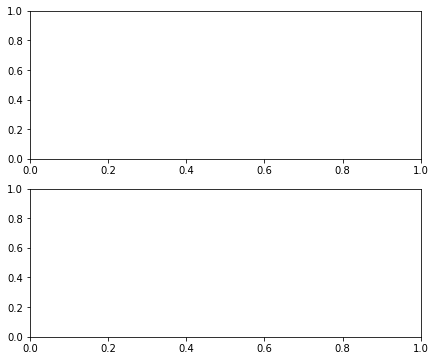

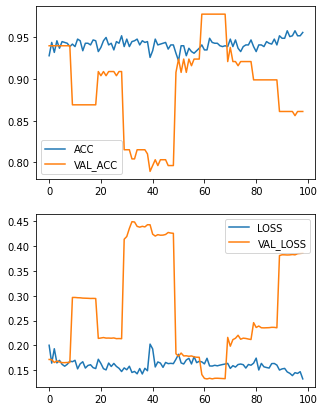

In [23]:
learning_curve()